In [1]:
import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cftime
from collections import OrderedDict

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

Set working directory to current working directory (needed to open SST observations and working with ARE).

In [3]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43723,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:40073,Total threads: 1
Dashboard: /proxy/36969/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:33445,


Open the ACCESS-NRI default catalog:

In [4]:
catalog = intake.cat.access_nri

Create a dictionary with the information we need to open different configurations of ACCESS-OM2:

In [5]:
data = OrderedDict([
    ('1deg',   {'model': 'access-om2',
                'expt':'1deg_jra55_iaf_omip2_cycle?',  
                'desc': 'ACCESS-OM2'}),
    ('025deg', {'model': 'access-om2-025',
                'expt':'025deg_jra55_iaf_omip2_cycle?',
                'desc': 'ACCESS-OM2-025'}),
    ('01deg',  {'model': 'access-om2-01',
                'expt':'01deg_jra55v140_iaf*',
                'desc': 'ACCESS-OM2-01'})
])

Define a function that opens a scalar variable for all cycles of each ACCESS-OM2 configuration and calculate an annual average. This function applies an offset to the time axis in order to append subsequent cycles:

In [84]:
def global_scalar(ekey, variable, freq):
    expt = data[ekey]['expt']
    cat_subset = catalog.search(name = expt)

    for idx, name in enumerate((sorted(cat_subset.keys()))[::-1]):
        darray = cat_subset[name].search(variable = variable, frequency = freq).to_dask(xarray_open_kwargs=dict(use_cftime=True))
        darray = darray[variable]
        if idx == 0:
            annual_average = darray.resample(time = '1YE').mean('time')
        else:
            tmp = darray.resample(time = '1YE').mean('time')
            last_year = tmp.time.values[-1].year
            first_year = annual_average.time.values[0].year
            offset = str(last_year - first_year + 1) + 'YE'
            tmp = tmp.assign_coords(time = tmp.time - xr.coding.cftime_offsets.to_offset(offset))
            annual_average = xr.concat([tmp, annual_average], dim='time')
    return annual_average

Load the variables (note how we have different frequencies available for different experiments):

In [91]:
(sorted(cat_subset.keys()))

['01deg_jra55v140_iaf',
 '01deg_jra55v140_iaf_cycle2',
 '01deg_jra55v140_iaf_cycle3',
 '01deg_jra55v140_iaf_cycle4',
 '01deg_jra55v140_iaf_cycle4_jra55v150_extension']

In [85]:
temp_global_ave = {}
temp_global_ave['1deg'] = global_scalar('1deg', 'temp_global_ave', '1mon')
temp_global_ave['025deg'] = global_scalar('025deg', 'temp_global_ave', '1mon')
temp_global_ave['01deg'] = global_scalar('01deg', 'temp_global_ave', '1day')

In [86]:
temp_surface_ave = {}
temp_surface_ave['1deg'] = global_scalar('1deg', 'temp_surface_ave', '1day')
temp_surface_ave['025deg'] = global_scalar('025deg', 'temp_surface_ave', '1day')
temp_surface_ave['01deg'] = global_scalar('025deg', 'temp_surface_ave', '1day')

In [87]:
salt_surface_ave = {}
salt_surface_ave['1deg'] = global_scalar('1deg', 'salt_surface_ave', '1day')
salt_surface_ave['025deg'] = global_scalar('025deg', 'salt_surface_ave', '1day')
salt_surface_ave['01deg'] = global_scalar('025deg', 'salt_surface_ave', '1day')

In [88]:
ke_tot = {}
ke_tot['1deg'] = global_scalar('1deg', 'ke_tot', '1mon')
ke_tot['025deg'] = global_scalar('025deg', 'ke_tot', '1mon')
ke_tot['01deg'] = global_scalar('025deg', 'ke_tot', '1mon')

Open SST observations:

In [89]:
temp = np.loadtxt('/home/561/jn8053/g_e14/cosima-recipes/ACCESS-OM2-GMD-Paper-Figs/aravg.ann.ocean.90S.90N.v4.0.1.201901.asc')
sst = temp[:,1] + 18
sst_year = xr.cftime_range(start = '1880-07-01', periods = sst.size, 
                           freq = "A", calendar = "julian")
sst_year

CFTimeIndex([1880-12-31 00:00:00, 1881-12-31 00:00:00, 1882-12-31 00:00:00,
             1883-12-31 00:00:00, 1884-12-31 00:00:00, 1885-12-31 00:00:00,
             1886-12-31 00:00:00, 1887-12-31 00:00:00, 1888-12-31 00:00:00,
             1889-12-31 00:00:00,
             ...
             2010-12-31 00:00:00, 2011-12-31 00:00:00, 2012-12-31 00:00:00,
             2013-12-31 00:00:00, 2014-12-31 00:00:00, 2015-12-31 00:00:00,
             2016-12-31 00:00:00, 2017-12-31 00:00:00, 2018-12-31 00:00:00,
             2019-12-31 00:00:00],
            dtype='object', length=140, calendar='julian', freq='YE-DEC')

(-15340.0, 8765.0)

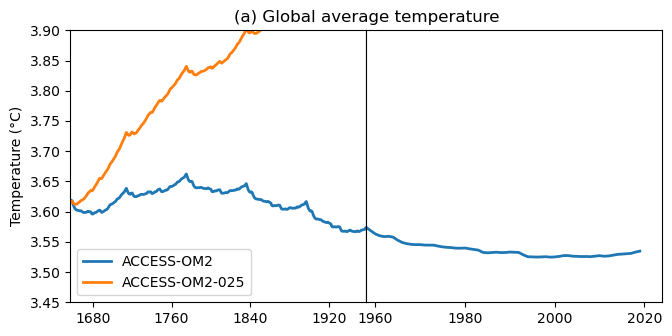

In [95]:
plt.figure(figsize = (16,8))

#############
## FIRST PLOT
ax = plt.axes([0.125, 0.545,0.185, 0.34])
for ekey in ['1deg', '025deg']:
    temp_global_ave[ekey].plot(ax = ax, label = data[ekey]['desc'], linewidth=2)
plt.legend()
ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('Temperature (°C)')
ax.set_ylim([3.45, 3.9])
ax.set_xlim([cftime.datetime(1657,1,1),cftime.datetime(1957,12,31)])

ax = plt.axes([0.31, 0.545,0.185, 0.34])
for ekey in ['1deg']:
    temp_global_ave[ekey].plot(ax = ax, label = data[ekey]['desc'], linewidth=2)
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('(a) Global average temperature',position=(0.0,1.0))
ax.set_ylim([3.45, 3.9])
ax.set_xlim([cftime.datetime(1958,1,1),cftime.datetime(2023,12,31)])

In [ ]:
plt.figure(figsize = (16,8))

#############
## FIRST PLOT
ax = plt.axes([0.125, 0.545,0.185, 0.34])
for ekey in ['1deg']:
    temp_global_ave[ekey].plot(ax = ax, label = data[ekey]['desc'], linewidth=2)
plt.legend()
ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('Temperature (°C)')
ax.set_ylim([3.45, 3.9])
ax.set_xlim([cftime.datetime(1657,1,1),cftime.datetime(1957,12,31)])

ax = plt.axes([0.31, 0.545,0.185, 0.34])
for ekey in ['1deg']:
    temp_global_ave[ekey].plot(ax = ax, label = data[ekey]['desc'], linewidth=2)
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('(a) Global average temperature',position=(0.0,1.0))
ax.set_ylim([3.45, 3.9])
ax.set_xlim([cftime.datetime(1958,1,1),cftime.datetime(2023,12,31)])

##############
## SECOND PLOT
ax = plt.axes([0.54, 0.545,0.185, 0.34])
for ekey in ['1deg']:
    temp_surface_ave[ekey].plot(ax = ax, label = data[ekey]['desc'], linewidth=2)
ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('Temperature (°C)')
ax.set_ylim([17.65, 18.6])
ax.set_xlim([cftime.datetime(1657,1,1),cftime.datetime(1957,12,31)])

ax = plt.axes([0.725, 0.545,0.185, 0.34])
for ekey in ['1deg']:
    temp_surface_ave[ekey].plot(ax = ax, label = data[ekey]['desc'], linewidth=2)
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('(b) Global average sea surface temperature',position=(0.0,1.0))
ax.set_xlim([cftime.datetime(1958,1,1),cftime.datetime(2023,12,31)])
## Add Obs:
ax.plot(sst_year,sst,'k--')
ax.set_ylim([17.65, 18.6])

#############
## THIRD PLOT
ax = plt.axes([0.125, 0.125,0.185, 0.34])
for ekey in ['1deg']:
    salt_surface_ave[ekey].plot(ax = ax, label = data[ekey]['desc'], linewidth=2)
ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('Salinity (g/kg)')
ax.set_ylim([34.43, 34.77])
ax.set_xlim([cftime.datetime(1657,1,1),cftime.datetime(1957,12,31)])

ax = plt.axes([0.31, 0.125,0.185, 0.34])
for ekey in ['1deg']:
    salt_surface_ave[ekey].plot(ax = ax, label = data[ekey]['desc'], linewidth=2)
ax.set_yticks([])
ax.set_ylabel('')
ax.set_title('(c) Global average surface salinity',position=(0.0,1.0))
ax.set_xlabel('Year',position=(0.0,1.0))
ax.set_ylim([34.43, 34.77])
ax.set_xlim([cftime.datetime(1958,1,1),cftime.datetime(2023,12,31)])

#############
## FOURTH PLOT
ax = plt.axes([0.54, 0.125,0.185, 0.34])
for ekey in ['1deg']:
    ke_tot[ekey].plot(ax = ax, label = data[ekey]['desc'], linewidth=2)
ax.set_title('')
plt.xlabel('')
plt.ylabel('Kinetic energy ($m^2/s^2$)')
ax.set_ylim([0, 3600])
ax.set_xlim([cftime.datetime(1657,1,1),cftime.datetime(1957,12,31)])

ax = plt.axes([0.725, 0.125,0.185, 0.34])
for ekey in ['1deg']:
    ke_tot[ekey].plot(ax = ax, label = data[ekey]['desc'], linewidth=2)
ax.set_yticks([])
ax.set_ylabel('')
ax.set_title('(d) Global average kinetic energy',position=(0.0,1.0))
ax.set_xlabel('Year',position=(0.0,1.0))
ax.set_ylim([0, 3600])
ax.set_xlim([cftime.datetime(1958,1,1),cftime.datetime(2023,12,31)])